In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math

import os
import folium
import geopandas as gpd

from shapely.geometry import Point, Polygon
import shapely.geometry
import requests

C:\anaconda3\envs\ada\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\anaconda3\envs\ada\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import  and transform data

In [2]:
def txt_to_dataframe(FOLDER_NAME,FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe and save it as a csv file 
    - FOLDER_NAME: name of the folder in which the txt file is
    - FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file and save it as a csv file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FOLDER_PATH = './Data/' + FOLDER_NAME
    FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".txt"
    CSV_FILE_PATH = FOLDER_PATH + '/' + FILE_NAME + ".csv"
    
    if os.path.exists(CSV_FILE_PATH) == False:
        with open(FILE_PATH, 'r', encoding="utf8") as f:
    
            for line in f:
                line = line.replace(u'\xa0','')
                listedline = line.split(':',1) # split around the ":" sign
        
                # take non-empty lines
                if len(listedline) > 1:
                    newDict[listedline[0]] = listedline[1].strip()
        
                # finish the dictionary for the line
                if listedline[0] == keys_list[-1]:
                    dict_list.append(newDict)
            
                    # reinitialize the dictionary for the next line
                    newDict = {key: None for key in keys_list}
    
            # transform list of dictionaries to dataframe
            df = pd.DataFrame(dict_list,columns=keys_list)
            
            # save dataframe file to a pickle file
            df.to_csv(CSV_FILE_PATH)
    
        return df
    
    else:
        
        df_csv = pd.read_csv(CSV_FILE_PATH,index_col = [0])
    
        return df_csv

In [3]:
# read csv files

keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews",keys_reviews)
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")

In [4]:
# read brewery csv with api
df_breweries_RB = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")
df_breweries_RB.drop('Unnamed: 0.1', axis = 1, inplace = True)
df_breweries_RB.drop('Unnamed: 0', axis = 1, inplace = True)
df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

In [5]:
# merge reviews and users on user id
df_reviews_beers_RB=pd.merge(df_reviews_RB, df_beers_RB[['beer_id','nbr_ratings']], how="left", on=['beer_id'])

# merge reviews and breweries on brewery id
df_all_RB = pd.merge(df_reviews_beers_RB, df_breweries_RB, how='left', on=['brewery_id'])

df_all_RB.rename(columns={"location": "brewery_location"}, inplace=True)

df_all_RB = df_all_RB.drop_duplicates(subset=['beer_id','user_name','user_id'],keep = 'first')

# keep only keys of interest
keys_to_drop = ['appearance','aroma', 'palate', 'taste', 'text', 'date', 'user_id','user_name']
df_interest_RB= df_all_RB.drop(keys_to_drop, axis=1)
print(df_interest_RB.shape)
df_interest_RB.rename(columns={"nbr_ratings": "nbr_ratings_per_beer"}, inplace=True)

#keeping only beers with more than 3 reviews
df_interest_RB_BIS = df_interest_RB[df_interest_RB.nbr_ratings_per_beer>3]
print(df_interest_RB.shape)

(7121987, 14)
(7121987, 14)


In [6]:
print(df_interest_RB_BIS.shape)

(6785189, 14)


In [7]:
df_interest_RB_BIS.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,overall,rating,nbr_ratings_per_beer,brewery_location,name,nbr_beers,latitude,longitude
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,8,1.9,10,Gabon,Sobraga,3.0,0.303409,9.501448


In [8]:
# mean rating per brewery
df_interest_RB.groupby('brewery_id').agg('mean')[['rating','abv']].sort_values(by='rating', ascending=False)

# mean rating per style
df_interest_RB.groupby('style').agg('mean')[['rating','abv']].sort_values(by='rating', ascending=False)

# mean rating per style and brewery
df_interest_RB.groupby(['style','brewery_id']).agg('mean')[['rating','abv']].sort_values(by=['style','rating'], ascending=False)

rating  abv
style                   brewery_id               
Zwickel/Keller/Landbier 24791       4.700000  5.0
                        23412       4.350000  4.6
                        26734       4.300000  NaN
                        5848        4.233333  4.9
                        10173       4.200000  5.2
...                                      ...  ...
Abbey Dubbel            14149       1.600000  6.5
                        28398       1.500000  7.0
                        58          1.300000  NaN
                        21799       1.000000  5.2
                        18761       0.900000  5.4

[195813 rows x 2 columns]

In [9]:
df_interest_RB.drop(['name'], axis = 1, inplace = True)
df_interest_RB.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,overall,rating,nbr_ratings_per_beer,brewery_location,nbr_beers,latitude,longitude
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,8,2.0,1,Gabon,3.0,0.303409,9.501448
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,8,1.9,10,Gabon,3.0,0.303409,9.501448
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.6,10,Gabon,3.0,0.303409,9.501448
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,5,1.5,10,Gabon,3.0,0.303409,9.501448
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,7,1.9,10,Gabon,3.0,0.303409,9.501448


In [10]:
Lat = df_breweries_RB['latitude']
Lon = df_breweries_RB['longitude']

## Europe

In [11]:
min_lon = -15 #-15 Europe, -5 Eq test
max_lon = 35 #35 Europe, 45 Eq test
min_lat = 30 #30 Europe, -10 Eq test
max_lat = 60 #60 Europe, 10 Eq test
res = 0.5 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [12]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [13]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')


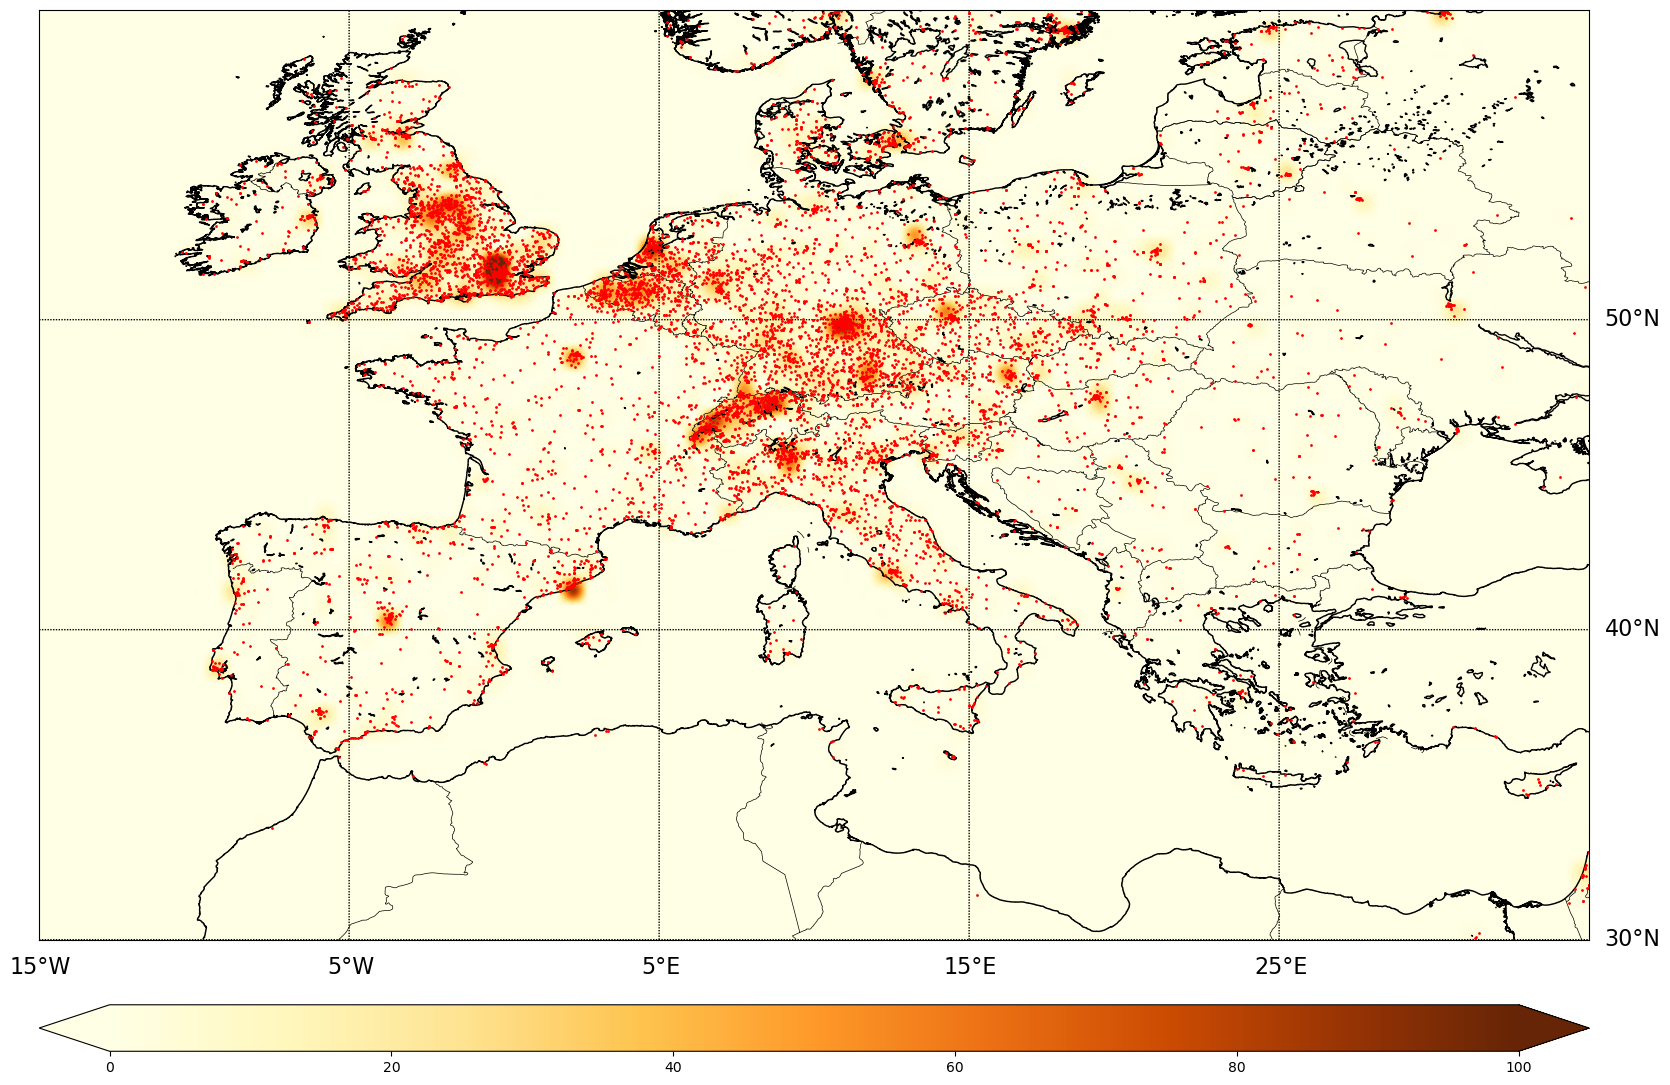

In [14]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=100)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

## Switzerland

In [15]:
min_lon = 5 #-15 Europe, -5 Eq test
max_lon = 11 #35 Europe, 45 Eq test
min_lat = 45 #30 Europe, -10 Eq test
max_lat = 48 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [16]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [17]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

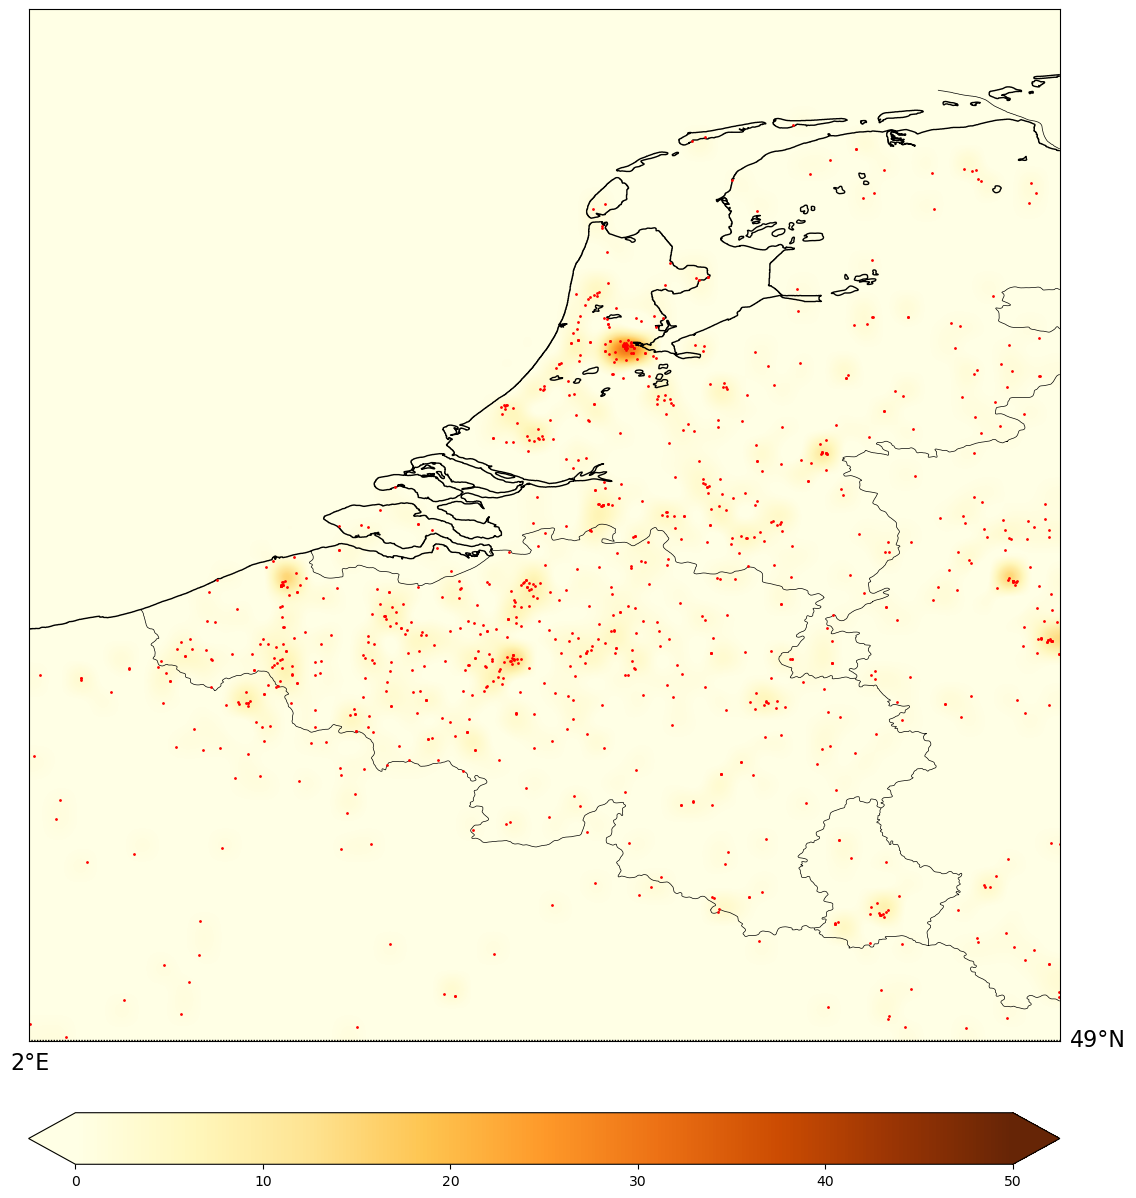

In [48]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=50)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

In [19]:
min_lon = 2 #-15 Europe, -5 Eq test
max_lon = 7 #35 Europe, 45 Eq test
min_lat = 49 #30 Europe, -10 Eq test
max_lat = 54 #60 Europe, 10 Eq test
res = 0.1 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [20]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [21]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')

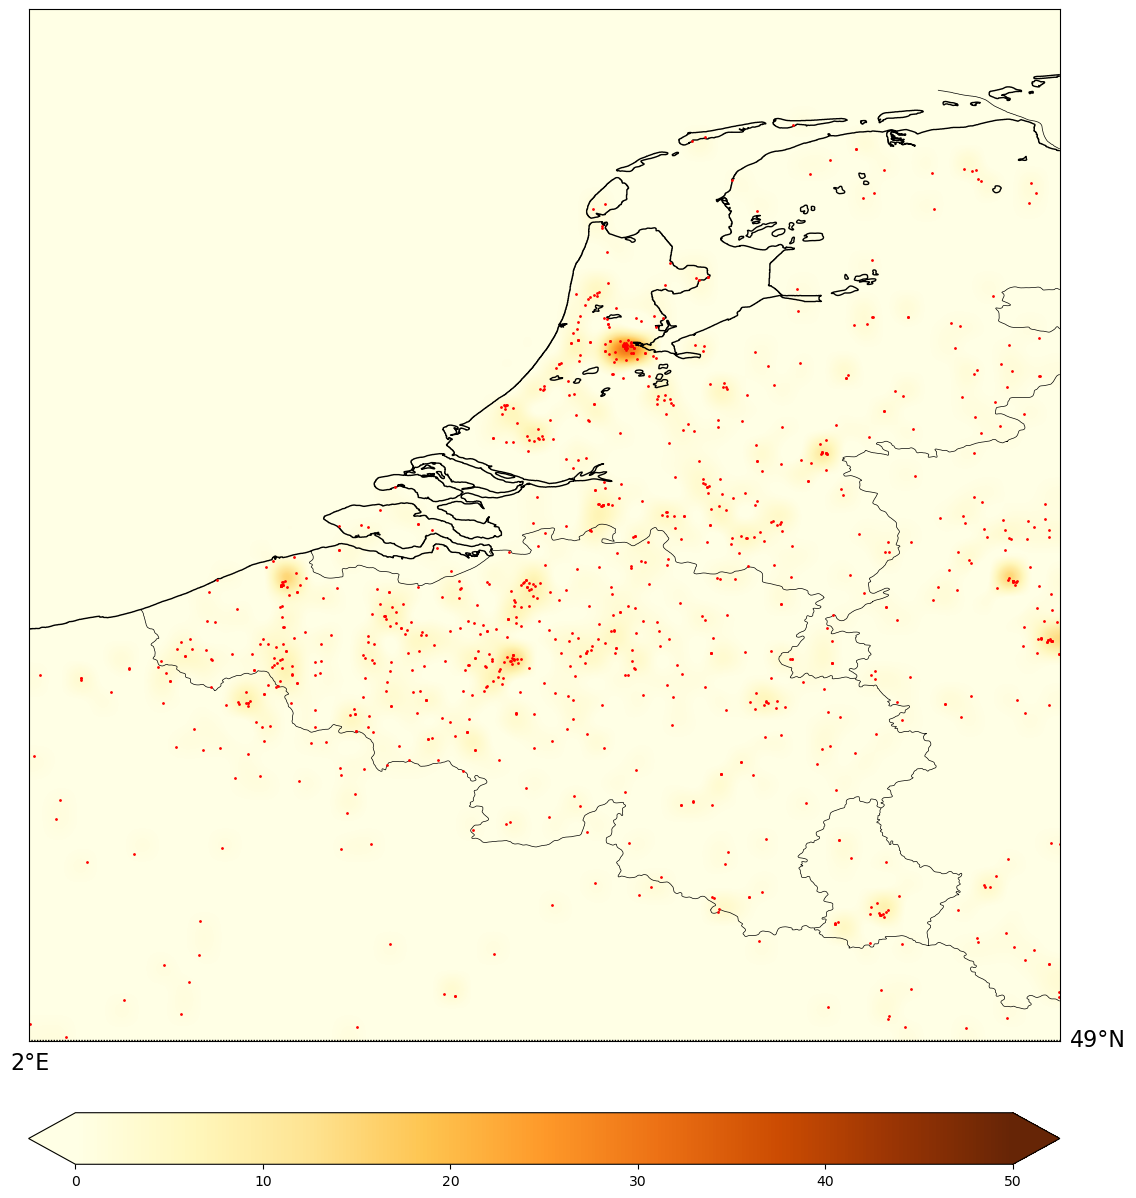

In [22]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=50)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)

In [23]:
df_latlng = pd.read_csv("./Data/breweries_api_Baptiste_version.csv")

In [24]:
print(df_latlng.shape)
df_latlng = df_latlng.dropna()
print(df_latlng.shape)

(24185, 8)
(21630, 8)


Add the geometry and use geopandas cities and world dataframes

In [25]:
gdf_bre_world = gpd.GeoDataFrame(
   df_latlng, geometry=gpd.points_from_xy(df_latlng.longitude, df_latlng.latitude))

gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

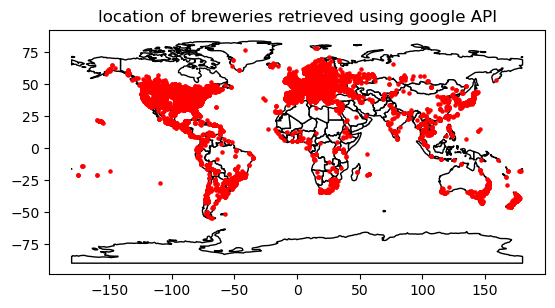

In [26]:
fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


gdf_bre_world.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title("location of breweries retrieved using google API")
plt.show();

In [27]:
# Extract a shapefile with switzerland boundaries of cantons
fname = "./Data/Cities.shp"

df = gpd.read_file(fname)
df = df.set_crs(epsg=4326)



# PIP test with 'within'
gdf_bre_world[gdf_bre_world['geometry'].within(df['geometry'])]   # True


num_breweries_per_city = df.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                  left_index=True, right_index=True, how="left")
num_breweries_per_city.head(1)
num_breweries_per_city = gdf_bre_world.merge(gpd.sjoin(gdf_bre_world, df).groupby("index_right").size().rename("points"),
                                             left_index=True, right_index=True, how="left")
inp, res = df.sindex.query_bulk(gdf_bre_world.geometry, predicate='intersects')
gdf_bre_world['intersects'] = np.isin(np.arange(0, len(gdf_bre_world)), inp)
print((gdf_bre_world['intersects']==True).sum())
print((gdf_bre_world['intersects']==False).sum())

df_with_city_pop=gpd.sjoin(gdf_bre_world, df)
df_with_city_pop.drop(df_with_city_pop.columns[[0,1,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
df_with_city_pop.head(3)



C:\anaconda3\envs\ada\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\anaconda3\envs\ada\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


10587
11043


,brewery_id,location,name,nbr_beers,latitude,longitude,geometry,intersects,index_right,name_conve,max_pop_al
0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True,2956,Libreville,483355.0
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,54.520266,-6.025840,POINT (-6.02584 54.52027),True,579,Belfast,450406.0
4,24297,Northern Ireland,Brewbot Belfast,3,54.575613,-5.917369,POINT (-5.91737 54.57561),True,579,Belfast,450406.0


In [28]:
gdf_bre_world

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name,nbr_beers,latitude,longitude,geometry,intersects
0,0,0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True
1,1,1,13538,Northern Ireland,Ards Brewing Co.,13,54.553377,-5.567928,POINT (-5.56793 54.55338),False
2,2,2,22304,Northern Ireland,Barrahooley Craft Brewery,4,54.520266,-6.025840,POINT (-6.02584 54.52027),True
3,3,3,22818,Northern Ireland,Boundary,66,54.601370,-5.831428,POINT (-5.83143 54.60137),False
4,4,4,24297,Northern Ireland,Brewbot Belfast,3,54.575613,-5.917369,POINT (-5.91737 54.57561),True
...,...,...,...,...,...,...,...,...,...,...
24180,24180,24184,28180,Albania,Shoqeria Picana,1,41.329282,19.824385,POINT (19.82438 41.32928),True
24181,24181,24185,1107,Albania,Stefani & Co,11,41.357019,19.745588,POINT (19.74559 41.35702),False
24182,24182,24186,9355,Albania,Hotel Martini,1,40.457752,19.485546,POINT (19.48555 40.45775),True
24183,24183,24187,9928,Albania,Rozafa Brewery,1,42.046439,19.493617,POINT (19.49362 42.04644),True


In [29]:
world=world.set_crs(epsg=4326, allow_override=True)
gdf_bre_bis = gdf_bre_world.sjoin(world, how="inner", predicate='within')
print(gdf_bre_bis.crs)
print(world.crs)
gdf_bre_world = gdf_bre_world.set_crs(epsg=4326)
gdf_with_breweries =  gdf_bre_world.sjoin(world, how="inner", predicate='intersects')

epsg:4326
epsg:4326


In [30]:
contain_values = gdf_with_breweries[gdf_with_breweries['location'].str.contains('United States')]
contain_values

gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('United States'), 'location'] = 'United States of America'
gdf_with_breweries.head(3)

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est
0,0,0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True,68,2172579.0,Africa,Gabon,GAB,16874
2,2,2,22304,Northern Ireland,Barrahooley Craft Brewery,4,54.520266,-6.025840,POINT (-6.02584 54.52027),True,143,66834405.0,Europe,United Kingdom,GBR,2829108
3,3,3,22818,Northern Ireland,Boundary,66,54.601370,-5.831428,POINT (-5.83143 54.60137),False,143,66834405.0,Europe,United Kingdom,GBR,2829108


In [31]:
#gdf_with_breweries[gdf_with_breweries['name_right'] == "United States"]
#gdf_with_breweries[gdf_with_breweries['name_right'].str.contains('Northern Ireland')]

In [32]:
## IT SEEMS LIKE NORTHENR IRELAND IS IN UNITED KINGDOM
gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('Northern Ireland'), 'location'] = 'United Kingdom'
gdf_with_breweries.loc[gdf_with_breweries['location'].str.contains('Wales'), 'location'] = 'United Kingdom'
gdf_with_breweries.shape

(20783, 16)

In [33]:
boolean = gdf_with_breweries['location'] == gdf_with_breweries['name_right']
gdf_with_breweries = gdf_with_breweries[boolean]

In [34]:
gdf_with_breweries.head(1)

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est
0,0,0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True,68,2172579.0,Africa,Gabon,GAB,16874


In [35]:
mean_rating_per_brewery = df_interest_RB_BIS.groupby('brewery_id').agg('mean')[['rating','abv']].sort_values(by='rating', ascending=False)
mean_rating_per_brewery.head(1)
(mean_rating_per_brewery.index == 22304).sum()
mean_rating_per_brewery.shape
df_all_RB.shape

(7121987, 22)

In [36]:
merged = pd.merge(gdf_with_breweries, mean_rating_per_brewery, left_on='brewery_id', right_on='brewery_id', how='left')
#merged = merged.sort_values(by='rating', ascending=False)
merged.head(10)
merged['rating'].isna().sum()
merged = merged.dropna(axis=0)
merged.head(1)

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est,rating,abv
0,0,0,3198,Gabon,Sobraga,3,0.303409,9.501448,POINT (9.50145 0.30341),True,68,2172579.0,Africa,Gabon,GAB,16874,1.837838,4.689189


In [37]:
merged_City = merged.groupby('intersects').agg('mean')['rating'].to_frame()
print(merged_City)
merged.groupby('intersects').agg('mean')['nbr_beers'].to_frame()
# Perform significance test for all breweries inside and outside out the city

              rating
intersects          
False       3.079672
True        3.149895


,nbr_beers
intersects,
False,22.609200
True,36.148737


In [38]:
mean_rating_sytle_brewery = df_interest_RB_BIS.groupby(['style','brewery_id']).agg('mean')[['rating','abv']].sort_values(by=['style','rating'],
                                                                                                                            ascending=False)
mean_rating_sytle_brewery['brewery_id'] = mean_rating_sytle_brewery.index.get_level_values(1)
mean_rating_sytle_brewery.index = mean_rating_sytle_brewery.index.get_level_values(0)
mean_rating_sytle_brewery['style'] = mean_rating_sytle_brewery.index
mean_rating_sytle_brewery

,rating,abv,brewery_id,style
style,,,,
Zwickel/Keller/Landbier,4.233333,4.900000,5848,Zwickel/Keller/Landbier
Zwickel/Keller/Landbier,3.900000,5.000000,4659,Zwickel/Keller/Landbier
Zwickel/Keller/Landbier,3.885714,5.100000,27672,Zwickel/Keller/Landbier
Zwickel/Keller/Landbier,3.875000,5.500000,16454,Zwickel/Keller/Landbier
Zwickel/Keller/Landbier,3.861111,4.944444,20684,Zwickel/Keller/Landbier
...,...,...,...,...
Abbey Dubbel,2.200000,7.200000,10100,Abbey Dubbel
Abbey Dubbel,2.200000,7.000000,5897,Abbey Dubbel
Abbey Dubbel,2.180000,NaN,2478,Abbey Dubbel


In [39]:
merged_style = pd.merge(merged, mean_rating_sytle_brewery, left_on='brewery_id', right_on='brewery_id', how='left').sort_values(by=['rating_x'],
                                                                                                                            ascending=False)
merged_style
#merged_style[merged_style['name_left'] == "Abita Brewing Company"]

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,...,pop_est,continent,name_right,iso_a3,gdp_md_est,rating_x,abv_x,rating_y,abv_y,style
53622,2633,2633,29502,Italy,77 Biscuits Brewing Co,6,45.787505,11.719324,POINT (11.71932 45.78751),False,...,6.029740e+07,Europe,Italy,ITA,2003576,4.675000,4.300000,4.675000,4.3,Golden Ale/Blond Ale
56043,704,704,11664,Mexico,Microcerveceria La Legendaria,5,22.130612,-101.019217,POINT (-101.01922 22.13061),True,...,1.275755e+08,North America,Mexico,MEX,1268870,4.660000,6.000000,4.660000,6.0,American Pale Ale
55904,522,522,17276,Mexico,Cervecería Del Llano,7,19.432877,-99.183205,POINT (-99.18321 19.43288),True,...,1.275755e+08,North America,Mexico,MEX,1268870,4.650000,6.500000,4.650000,6.5,American Strong Ale
21309,16276,16279,1282,United States of America,Foundry Ale Works,25,40.445715,-80.011272,POINT (-80.01127 40.44572),True,...,3.282395e+08,North America,United States of America,USA,21433226,4.580000,4.900000,4.580000,4.9,Stout
73894,8294,8294,10194,Argentina,Titus Cervecería Artesanal,1,-27.448870,-58.990702,POINT (-58.99070 -27.44887),True,...,4.493871e+07,South America,Argentina,ARG,445445,4.575000,5.500000,4.575000,5.5,Golden Ale/Blond Ale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73915,6840,6840,5407,Cambodia,Cambodia Brewery (Heineken),6,11.503349,104.994232,POINT (104.99423 11.50335),False,...,1.648654e+07,Asia,Cambodia,KHM,27089,1.125000,5.200000,1.125000,5.2,Pale Lager
1079,225,225,17453,China,Xinzheng Bianjing,1,34.396050,113.741610,POINT (113.74161 34.39605),True,...,1.397715e+09,Asia,China,CHN,14342903,1.114286,3.800000,1.114286,3.8,Pale Lager
21319,16280,16283,3466,United States of America,Gettysbrew Restaurant & Brewery,6,40.297109,-76.643114,POINT (-76.64311 40.29711),True,...,3.282395e+08,North America,United States of America,USA,21433226,1.017647,7.523077,1.100000,10.0,Barley Wine
21318,16280,16283,3466,United States of America,Gettysbrew Restaurant & Brewery,6,40.297109,-76.643114,POINT (-76.64311 40.29711),True,...,3.282395e+08,North America,United States of America,USA,21433226,1.017647,7.523077,1.014286,5.4,Bitter


In [40]:
merged_style.sort_values(by=['brewery_id'])

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,...,pop_est,continent,name_right,iso_a3,gdp_md_est,rating_x,abv_x,rating_y,abv_y,style
5860,13440,13443,1,United States of America,Abita Brewing Company,127,30.482108,-90.055018,POINT (-90.05502 30.48211),False,...,328239523.0,North America,United States of America,USA,21433226,3.005388,5.855622,3.611940,6.000000,Sweet Stout
5871,13440,13443,1,United States of America,Abita Brewing Company,127,30.482108,-90.055018,POINT (-90.05502 30.48211),False,...,328239523.0,North America,United States of America,USA,21433226,3.005388,5.855622,2.880000,4.800000,Kölsch
5873,13440,13443,1,United States of America,Abita Brewing Company,127,30.482108,-90.055018,POINT (-90.05502 30.48211),False,...,328239523.0,North America,United States of America,USA,21433226,3.005388,5.855622,3.648855,9.641221,Imperial Stout
5874,13440,13443,1,United States of America,Abita Brewing Company,127,30.482108,-90.055018,POINT (-90.05502 30.48211),False,...,328239523.0,North America,United States of America,USA,21433226,3.005388,5.855622,3.295526,7.000000,Imperial Pils/Strong Pale Lager
5875,13440,13443,1,United States of America,Abita Brewing Company,127,30.482108,-90.055018,POINT (-90.05502 30.48211),False,...,328239523.0,North America,United States of America,USA,21433226,3.005388,5.855622,3.609524,8.642857,Imperial IPA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62880,1600,1600,31976,Canada,Godspeed Brewery,3,43.672410,-79.319390,POINT (-79.31939 43.67241),True,...,37589262.0,North America,Canada,CAN,1736425,3.570000,5.480000,3.725000,4.700000,Stout
68119,22884,22888,32005,Belgium,Leuven Institue For Beer Research,1,50.866487,4.674312,POINT (4.67431 50.86649),False,...,11484055.0,Europe,Belgium,BEL,533097,3.075000,5.700000,3.075000,5.700000,Belgian Ale
60555,1247,1247,32011,Canada,Blind Enthusiasm,3,53.512399,-113.476359,POINT (-113.47636 53.51240),True,...,37589262.0,North America,Canada,CAN,1736425,3.383333,4.900000,3.425000,5.200000,India Pale Ale (IPA)
60556,1247,1247,32011,Canada,Blind Enthusiasm,3,53.512399,-113.476359,POINT (-113.47636 53.51240),True,...,37589262.0,North America,Canada,CAN,1736425,3.383333,4.900000,3.375000,5.000000,Bitter


In [41]:
# mean rating per brewery
df_interest_RB.groupby('brewery_id').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style
df_interest_RB.groupby('style').agg('mean')['rating'].to_frame().sort_values(by='rating', ascending=False)

# mean rating per style and brewery
df_interest_RB.groupby(['style','brewery_id']).agg('mean')['rating'].to_frame().sort_values(by=['style','rating'], ascending=False)

rating
style                   brewery_id          
Zwickel/Keller/Landbier 24791       4.700000
                        23412       4.350000
                        26734       4.300000
                        5848        4.233333
                        10173       4.200000
...                                      ...
Abbey Dubbel            14149       1.600000
                        28398       1.500000
                        58          1.300000
                        21799       1.000000
                        18761       0.900000

[195813 rows x 1 columns]

## Distance computation

In [42]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gd_breweries, gd_cities):

    n_breweries = np.array(list(gd_breweries.geometry.apply(lambda x: (x.x, x.y))))
    n_cities = np.array(list(gd_cities.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(n_cities)
    dist, idx = btree.query(n_breweries, k=1)
    gd_cities_nearest = gd_cities.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gd_breweries.reset_index(drop=True),
            gd_cities_nearest,
            pd.Series(dist, name='dist'),
        ], 
        axis=1)

    return gdf



C:\Users\Bastien Amez-Droz\AppData\Local\Temp\ipykernel_21968\3185485474.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_point_cities = df.centroid


,geometry,name,pop
0,POINT (9.93341 57.03615),Aalborg,101616.0
1,POINT (10.18027 56.16552),Aarhus,227100.0
2,POINT (7.33877 5.08421),Aba,851210.0
3,POINT (48.27875 30.34153),Abadan,260078.0
4,POINT (-48.87708 -1.72292),Abaetetuba,79420.0


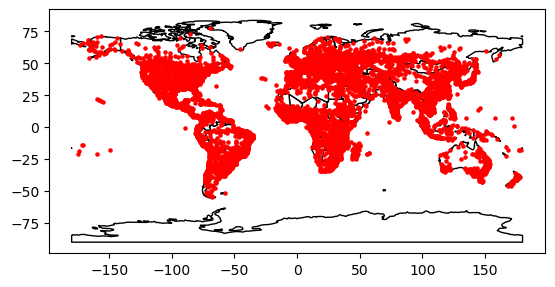

In [43]:
df_point_cities = df.centroid
gdf_point_cities = gpd.GeoDataFrame(geometry=gpd.GeoSeries(df_point_cities))
gdf_point_cities['name'] = df['name_conve']
gdf_point_cities['pop'] = df['max_pop_al']
fig, ax = plt.subplots()
world.plot(ax=ax, color='white', edgecolor='black')

gdf_point_cities.plot(ax=ax, marker='o', color='red', markersize=5)
gdf_point_cities.head()

In [44]:
merged_style = ckdnearest(merged_style,gdf_point_cities)

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,...,iso_a3,gdp_md_est,rating_x,abv_x,rating_y,abv_y,style,name,pop,dist
0,2633,2633,29502,Italy,77 Biscuits Brewing Co,6,45.787505,11.719324,POINT (11.71932 45.78751),False,...,ITA,2003576,4.675,4.3,4.675,4.3,Golden Ale/Blond Ale,Treviso,177309.0,0.544947
1,704,704,11664,Mexico,Microcerveceria La Legendaria,5,22.130612,-101.019217,POINT (-101.01922 22.13061),True,...,MEX,1268870,4.660,6.0,4.660,6.0,American Pale Ale,San Luis Potosi,934590.0,0.059146
2,522,522,17276,Mexico,Cervecería Del Llano,7,19.432877,-99.183205,POINT (-99.18321 19.43288),True,...,MEX,1268870,4.650,6.5,4.650,6.5,American Strong Ale,Mexico City,10811002.0,0.104940
3,16276,16279,1282,United States of America,Foundry Ale Works,25,40.445715,-80.011272,POINT (-80.01127 40.44572),True,...,USA,21433226,4.580,4.9,4.580,4.9,Stout,Pittsburgh,1232535.0,0.028706
4,8294,8294,10194,Argentina,Titus Cervecería Artesanal,1,-27.448870,-58.990702,POINT (-58.99070 -27.44887),True,...,ARG,445445,4.575,5.5,4.575,5.5,Golden Ale/Blond Ale,Resistencia,349753.0,0.008350


In [45]:
#Distance are quite short and we can approximate the earth to be a sphere to tranform it into kilometers
merged_style['dist_km'] = merged_style['dist']*math.pi/180*6371
merged_style.head()

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,...,gdp_md_est,rating_x,abv_x,rating_y,abv_y,style,name,pop,dist,dist_km
0,2633,2633,29502,Italy,77 Biscuits Brewing Co,6,45.787505,11.719324,POINT (11.71932 45.78751),False,...,2003576,4.675,4.3,4.675,4.3,Golden Ale/Blond Ale,Treviso,177309.0,0.544947,60.595310
1,704,704,11664,Mexico,Microcerveceria La Legendaria,5,22.130612,-101.019217,POINT (-101.01922 22.13061),True,...,1268870,4.660,6.0,4.660,6.0,American Pale Ale,San Luis Potosi,934590.0,0.059146,6.576759
2,522,522,17276,Mexico,Cervecería Del Llano,7,19.432877,-99.183205,POINT (-99.18321 19.43288),True,...,1268870,4.650,6.5,4.650,6.5,American Strong Ale,Mexico City,10811002.0,0.104940,11.668849
3,16276,16279,1282,United States of America,Foundry Ale Works,25,40.445715,-80.011272,POINT (-80.01127 40.44572),True,...,21433226,4.580,4.9,4.580,4.9,Stout,Pittsburgh,1232535.0,0.028706,3.191955
4,8294,8294,10194,Argentina,Titus Cervecería Artesanal,1,-27.448870,-58.990702,POINT (-58.99070 -27.44887),True,...,445445,4.575,5.5,4.575,5.5,Golden Ale/Blond Ale,Resistencia,349753.0,0.008350,0.928530


In [49]:
#Brasserie la plus perdue
merged_style[merged_style['dist_km']==max(merged_style['dist_km'])]

,Unnamed: 0.1,Unnamed: 0,brewery_id,location,name_left,nbr_beers,latitude,longitude,geometry,intersects,...,gdp_md_est,rating_x,abv_x,rating_y,abv_y,style,name,pop,dist,dist_km
75624,10253,10255,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,...,3051,2.595238,5.3678,2.604673,6.000000,Dunkler Bock,Narsarsuaq,145.0,16.092559,1789.410904
75625,10253,10255,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,...,3051,2.595238,5.3678,2.631522,6.000000,Spice/Herb/Vegetable,Narsarsuaq,145.0,16.092559,1789.410904
75626,10253,10255,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,...,3051,2.595238,5.3678,2.625806,4.800000,Wheat Ale,Narsarsuaq,145.0,16.092559,1789.410904
75627,10253,10255,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,...,3051,2.595238,5.3678,2.886207,5.000000,Brown Ale,Narsarsuaq,145.0,16.092559,1789.410904
75628,10253,10255,13431,Greenland,Grønland Ice Cap Beer,8,76.7,-41.2,POINT (-41.20000 76.70000),False,...,3051,2.595238,5.3678,2.519780,4.831868,Amber Lager/Vienna,Narsarsuaq,145.0,16.092559,1789.410904
